# Permutation Importance vs Random Forest Feature Importance (MDI)

Author: scikit-learn.org

Article from [scikit-learn.org](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [9]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier

# Data Loading and Feature Engineering

In [2]:
X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [4]:
categorical_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy='mean')

preprocessing = ColumnTransformer(
    [
        ('cat', categorical_encoder, categorical_columns),
        ('num', numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ('preprocess', preprocessing),
        ('classifier', RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

# Accuracy of the model

In [5]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


# Tree's Feature Importance from Mean Decrease in Impurity (MDI)

In [7]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

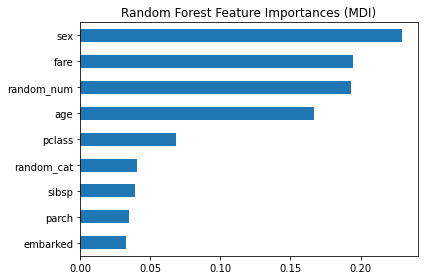

In [8]:
ax = mdi_importances.plot.barh()
ax.set_title('Random Forest Feature Importances (MDI)')
ax.figure.tight_layout()

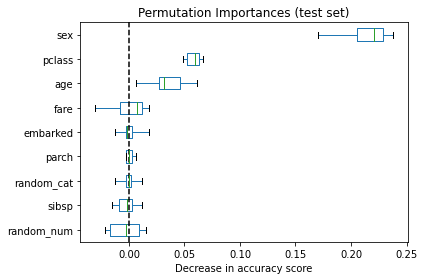

In [12]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx= result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances (test set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

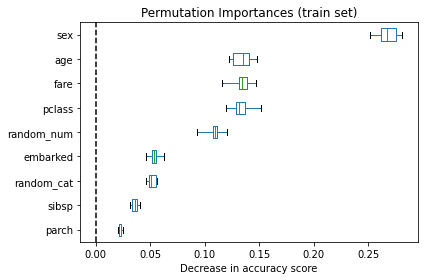

In [13]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx= result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances (train set)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

In [14]:
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

In [15]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.810
RF test accuracy: 0.832


In [16]:
train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [17]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

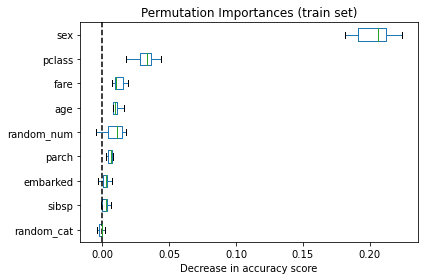

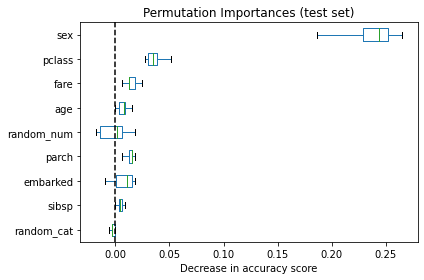

In [18]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()